In [17]:
!pip install -q -U torch-pca

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def plot_2d_points_on_surface(surface_func, points, num_frames=100, save_path="animation.gif",zoom_out_factor=1,discretization = 128):
    # Create a meshgrid for the surface
    points = np.array(points)
    MAX = np.max(points, axis=0)
    MIN = np.min(points, axis=0)
    MEAN = (MAX+MIN)/2
    SCALE = zoom_out_factor*(MAX-MIN)
    LBORDER=MEAN-SCALE
    RBORDER=MEAN+SCALE
    
    x = np.linspace(LBORDER[0], RBORDER[0], discretization)
    y = np.linspace(LBORDER[1], RBORDER[1], discretization)
    X, Y = np.meshgrid(x, y)
    Z = surface_func(X, Y)

    # Set up the figure
    fig, ax = plt.subplots()
    
    # Plot the surface with a colormap
    c = ax.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
    fig.colorbar(c, ax=ax, label='Third Dimension (Z)')

    # Initialize a point and trail
    point, = ax.plot([], [], 'ro', markersize=6)  # Point in red
    trail_x, trail_y = [], []

    def update(frame):
        # Get the current point based on the frame number
        idx = frame % len(points)
        px, py, pz = points[idx]
        
        # Update the point's position
        point.set_data(px, py)

        # Store the trail
        trail_x.append(px)
        trail_y.append(py)
        
        # Update the trail line
        ax.plot(trail_x, trail_y, color='blue', alpha=0.5)

        return point,

    # Set the limits
    ax.set_xlim([LBORDER[0], RBORDER[0]])
    ax.set_ylim([LBORDER[1], RBORDER[1]])
    print("saving animation...")
    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=False)
    ani.save(save_path, writer='imagemagick')
    plt.close(fig)
    

saving animation...


/tmp/ipykernel_30/784125.py:37: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(px, py)


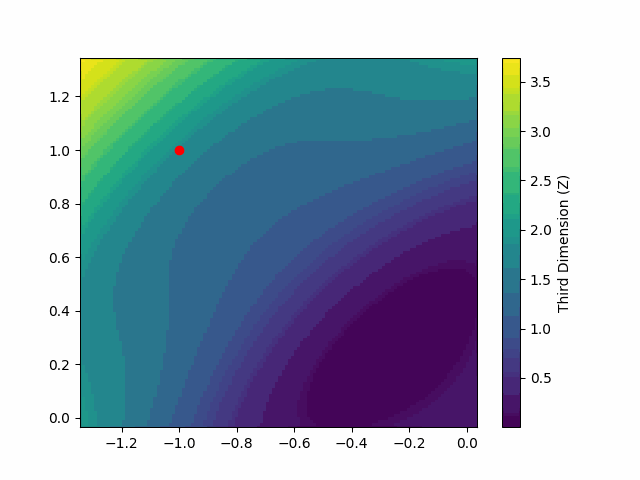

In [69]:
import torch
import numpy as np

from IPython.display import Image
def f(x : torch.Tensor) -> torch.Tensor:
    res = x[0]**2+x[1]**2+torch.cos(5*(-x[0]+x[1]))/5
    return torch.abs(res)

guess = torch.Tensor([-1,1])
guess.requires_grad=True
points = []
step = 0.01

for i in range(200):
    loss = f(guess)
    loss.backward()
    points.append(torch.Tensor([guess[0],guess[1],loss]))
    with torch.no_grad():
        guess-=step*guess.grad
    guess.grad.zero_()

def ff(x,y): return f(torch.tensor([x,y]))

anim_path = "animation.gif"
plot_2d_points_on_surface(ff,points,save_path=anim_path)
Image(filename=anim_path)

In [3]:
import torch
import torch.nn as nn
import torchvision

class Flatten(nn.Module):
    def __init__(self,base):
        super(Flatten, self).__init__()
        self.base = base
        pass
    def __call__(self,x): return self.base(x.reshape((x.shape[0],-1)))

class LeNet(nn.Module):
    """LeNet classification network that works on 28 by 28 by 3 images"""
    def __init__(self,num_classes):
        super(LeNet, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=3,out_channels=20,kernel_size=(5,5),stride=(1,1)),
            nn.Tanh(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(in_channels=20,out_channels=50,kernel_size=(5,5),stride=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            Flatten(nn.Linear(800,300)),
            nn.ReLU(),
            nn.Linear(300,num_classes),
            nn.Softmax()
        ])
    
    def forward(self, x : torch.Tensor):
        if len(x.shape)==3:
            x=x.unsqueeze(0)
        for l in self.layers:
            x = l(x)
        return x
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

transform = T.Compose([
    T.Resize((28,28)),
    T.ToTensor(),
    T.Normalize(0,1),
])

#download https://www.kaggle.com/datasets/prasunroy/natural-images
dataset = torchvision.datasets.ImageFolder(
    "/kaggle/input/natural-images/natural_images",
    transform=transform)

# достанем классы
targets = [label for _, label in dataset.imgs]

# разделим датасет
train_idx, test_idx = train_test_split(
    list(range(len(targets))),
    test_size=0.05,
    stratify=targets
)

# создадим даталодеры
train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [184]:
def get_last_layer_tensor(model):
    return model.module.layers[8]

def get_class_name(cls_or_obj):
    return cls_or_obj.__class__.__name__ if not isinstance(cls_or_obj, type) else cls_or_obj.__name__

In [213]:
import torch.nn.functional as F
from torchmetrics import Accuracy
def train(model,train_loader,test_loader,optimizer,metric,device,epochs=20):
    train_acc = []
    test_acc = []
    model_weights = []
    for epoch in range(epochs):
        avg_train_acc = 0
        avg_test_acc = 0
        for batch in train_loader:
            images = batch[0].to(device)
            classes = batch[1].to(device)
            pred = model.forward(images)
            loss = F.cross_entropy(pred,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred_class = torch.argmax(pred, dim=1)
            avg_train_acc+=metric(pred_class,classes)

        for batch in test_loader:
            images = batch[0].to(device)
            classes = batch[1].to(device)
            with torch.no_grad():
                pred = model.forward(images)
                pred_class = torch.argmax(pred, dim=1)
                avg_test_acc+=metric(pred_class,classes)
        
        w = get_last_layer_tensor(model).weight.cpu().detach()
        
        avg_train_acc/=len(train_loader)
        avg_test_acc/=len(test_loader)

        print(f"Epoch {epoch}\tTrain accuracy {avg_train_acc:.2f}\tTest accuracy {avg_test_acc:.2f}")
        train_acc.append(avg_train_acc)
        test_acc.append(avg_test_acc)
        model_weights.append(w)
    return {
        "optimizer": get_class_name(optimizer),
        "train_acc":train_acc,
        "test_acc":test_acc,
        "model_weights":model_weights,
        "model": model
    }

In [317]:
num_classes = 8
epochs=20
metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
device = "cuda"

In [318]:
from torch.optim import AdamW, SGD, RMSprop, ASGD, Adagrad
from multiprocessing import Pool

def eval_optim(optim,lr):
    print(optim)
    device = "cuda"
    model = LeNet(num_classes)
    model=nn.DataParallel(model).to(device)
    optimizer = optim(model.parameters(),lr=lr)
    res = train(model,train_loader,test_loader,optimizer,metric,device,epochs=epochs)
    return res

optims =[
    AdamW,
    Adagrad,
    RMSprop
]
results = []
for opt in optims:
    results.append(eval_optim(opt,0.001))

<class 'torch.optim.adamw.AdamW'>
Epoch 0	Train accuracy 0.43	Test accuracy 0.60
Epoch 1	Train accuracy 0.65	Test accuracy 0.70
Epoch 2	Train accuracy 0.75	Test accuracy 0.75
Epoch 3	Train accuracy 0.78	Test accuracy 0.80
Epoch 4	Train accuracy 0.81	Test accuracy 0.79
Epoch 5	Train accuracy 0.82	Test accuracy 0.80
Epoch 6	Train accuracy 0.82	Test accuracy 0.81
Epoch 7	Train accuracy 0.84	Test accuracy 0.84
Epoch 8	Train accuracy 0.85	Test accuracy 0.84
Epoch 9	Train accuracy 0.85	Test accuracy 0.83
Epoch 10	Train accuracy 0.86	Test accuracy 0.80
Epoch 11	Train accuracy 0.86	Test accuracy 0.85
Epoch 12	Train accuracy 0.85	Test accuracy 0.83
Epoch 13	Train accuracy 0.87	Test accuracy 0.84
Epoch 14	Train accuracy 0.87	Test accuracy 0.84
Epoch 15	Train accuracy 0.87	Test accuracy 0.83
Epoch 16	Train accuracy 0.87	Test accuracy 0.83
Epoch 17	Train accuracy 0.87	Test accuracy 0.83
Epoch 18	Train accuracy 0.88	Test accuracy 0.83
Epoch 19	Train accuracy 0.88	Test accuracy 0.82
<class 'torch.op

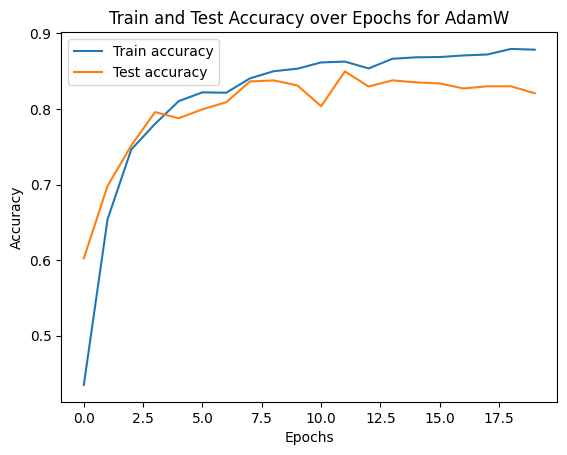

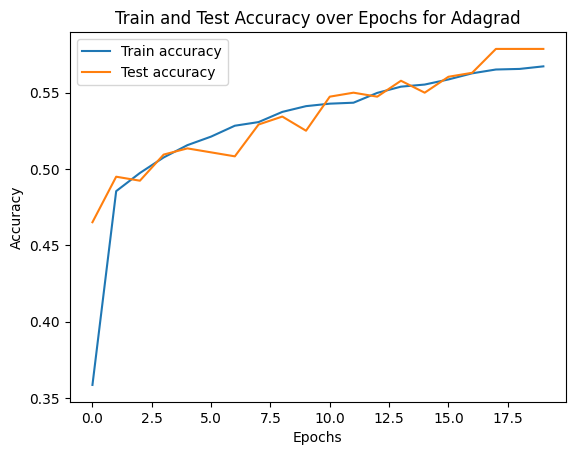

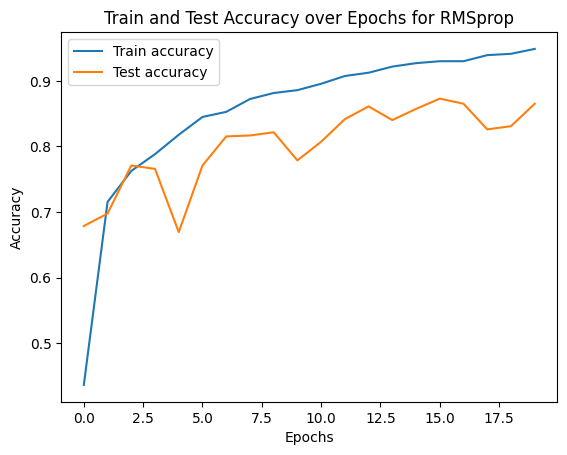

In [319]:
import matplotlib.pyplot as plt

for rec in results:
    train_acc = rec['train_acc']
    test_acc = rec['test_acc']
    # Plotting
    plt.plot([v.cpu() for v in train_acc], label='Train accuracy')
    plt.plot([v.cpu() for v in test_acc], label='Test accuracy')
    
    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy over Epochs for '+rec['optimizer'])
    
    # Adding legend
    plt.legend()
    
    # Show plot
    plt.show()

In [354]:
optimizer_index = 1
# collect last layer weights from all epochs of all runs
total_weights = []
for rec in results:
    for w in rec['model_weights']:
        total_weights.append(w)

# get flat version of last layer weights
total_weights_stacked=torch.stack(total_weights,axis=0)
weights_shape = total_weights[0].shape
flatten = total_weights_stacked.flatten(1)
flatten.shape

torch.Size([60, 2400])

In [355]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# scale last layer weights to do better job with PCA
# scaler = StandardScaler()
scaler = RobustScaler()
flatten_normalized = torch.tensor(scaler.fit_transform(flatten))
torch.mean(flatten_normalized,axis=0)

tensor([-0.0225, -0.1378,  0.1609,  ...,  0.2040, -0.2772,  0.2641],
       dtype=torch.float64)

PCA explained variance 0.782


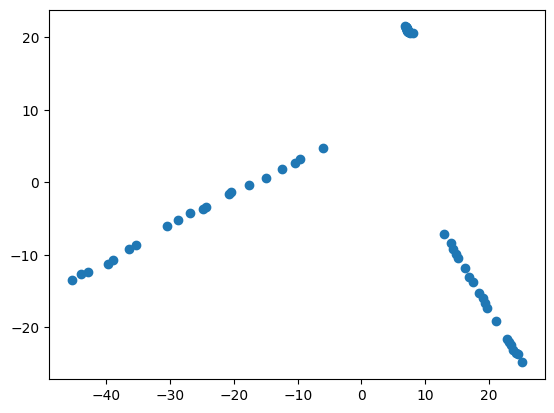

In [356]:
# now if we want to do 3d render of model loss function change, we need somehow
# learn how to map x,y coordinates to model weights. To do this we use PCA
from torch_pca import PCA
pca = PCA(n_components = 2)
features = pca.fit_transform(flatten_normalized)
pca_performance = float(sum(pca.explained_variance_ratio_))

# print how good our pca at capturing model weights variance
print(f"PCA explained variance {pca_performance:0.3}")

# render our weights features
plt.scatter(features[:,0],features[:,1])

In [357]:
def replace_last_layer_tensor(model,tensor):
    lastl = get_last_layer_tensor(model)
    with torch.no_grad():
        tensor=tensor.to(lastl.weight.device)
        lastl.weight+=tensor-lastl.weight

def get_first_n(dataloader, n):
    batches = []
    for i, batch in enumerate(dataloader):
        if i >= n:
            break
        batches.append(batch)
    return batches

def get_weights_from_pos(pos):
    pos = torch.tensor(pos,dtype=torch.double)
    # get full weights from lowdim representation
    weights = pca.inverse_transform(pos)
    # reverse scaler affects on weights
    weights = scaler.inverse_transform(weights)
    return torch.tensor(weights).reshape(weights_shape)

def get_test_score(model,test_batches):
    avg_test_acc = 0
    for batch in test_batches:
        images = batch[0].to(device)
        classes = batch[1].to(device)
        with torch.no_grad():
            pred = model.forward(images)
            pred_class = torch.argmax(pred, dim=1)
            avg_test_acc+=metric(pred_class,classes)
    return avg_test_acc/len(test_batches)

In [363]:
# get sample batches to evaluate our model
sample_model = results[optimizer_index]['model'].eval()
sample_batches = get_first_n(test_loader,3)

# loss function from model
def loss(pos):
    # convert small-dimensional pos vector to full weights tensor using PCA
    sample_weight = get_weights_from_pos(pos)
    # replace weights from model to computed one
    replace_last_layer_tensor(sample_model,sample_weight)
    # get evaluation metric on samples batches from test data loader
    res = get_test_score(sample_model,sample_batches)
    # return resulted metric
    return float(res)

def loss_xy(x,y): 
    return loss([x,y])

In [359]:
import warnings
import torch

# Suppress specific warning categories
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

loss_xy(-1000,10010)

0.546875

saving animation...


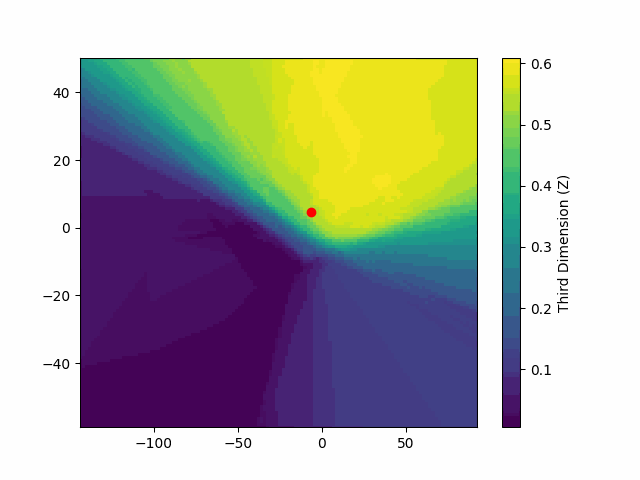

In [382]:
loss_xy_vec = np.vectorize(loss_xy)

# get adamW path
points = results[2]['model_weights']
points = torch.stack(points,axis=0).flatten(1)
points = torch.tensor(scaler.transform(points))
points = np.array(pca.transform(points))
points = [[v[0],v[1],loss(v)] for v in points]

anim_path = "model_loss_surface.gif"
plot_2d_points_on_surface(loss_xy_vec,points,save_path=anim_path,discretization=128,zoom_out_factor=3)
Image(filename=anim_path)